Example turbine locations:
   TurbID          x           y
0       1  3349.8515  5939.23193
1       2  3351.0017  6416.64673
2       3  3314.7797  6892.18395
3       4  3352.0940  7366.14203
4       5  3355.3420  7841.20175
Edge indices (source -> target):
[[  0   0   1   1   2   2   3   4   4   5   5   6   6   7   7   8   8   9
    9  10  14  15  15  16  16  17  17  18  18  19  19  20  20  21  21  22
   22  23  23  24  24  24  25  25  25  26  26  26  27  27  27  28  28  28
   29  29  29  30  30  30  31  31  32  33  34  34  37  38  38  39  39  39
   40  40  40  41  41  41  42  42  42  43  43  43  44  44  44  45  45  45
   46  46  46  47  47  48  48  48  49  49  49  50  50  50  51  51  51  52
   52  53  55  56  56  58  59  59  60  60  60  61  61  61  62  62  62  63
   63  63  64  64  64  65  65  65  66  66  66  67  67  67  68  68  68  69
   69  69  70  70  70  71  71  71  72  72  72  73  73  73  74  74  74  75
   75  75  76  76  76  77  77  77  78  78  78  83  84  84  85  85  85  86
  

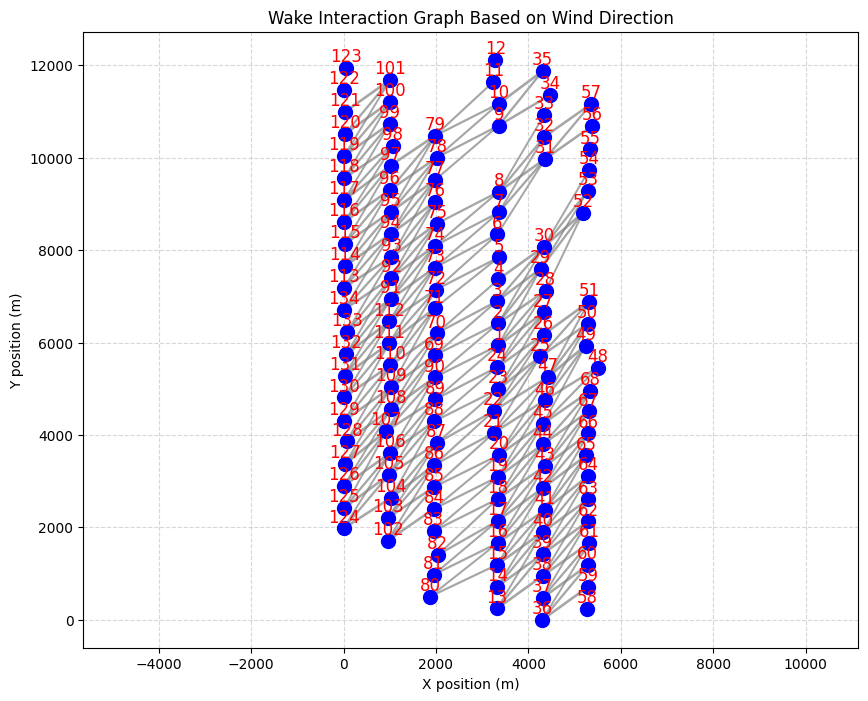

Edge from node 0 to node 88 with weight 0.166
Edge from node 0 to node 89 with weight 0.203
Edge from node 1 to node 68 with weight 0.202
Edge from node 1 to node 89 with weight 0.163
Edge from node 2 to node 68 with weight 0.168
Edge from node 2 to node 69 with weight 0.219
Edge from node 3 to node 69 with weight 0.169
Edge from node 4 to node 70 with weight 0.170
Edge from node 4 to node 71 with weight 0.208
Edge from node 5 to node 71 with weight 0.167
Edge from node 5 to node 72 with weight 0.207
Edge from node 6 to node 72 with weight 0.160
Edge from node 6 to node 73 with weight 0.200
Edge from node 7 to node 73 with weight 0.162
Edge from node 7 to node 74 with weight 0.210
Edge from node 8 to node 76 with weight 0.163
Edge from node 8 to node 77 with weight 0.211
Edge from node 9 to node 77 with weight 0.169
Edge from node 9 to node 78 with weight 0.202
Edge from node 10 to node 78 with weight 0.179
Edge from node 14 to node 79 with weight 0.188
Edge from node 15 to node 79 wit

In [2]:
# wind_power_forecasting/graph_construction.py

import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from config import SPATIAL_GRAPH_TYPE, SPATIAL_RADIUS, K_NEIGHBORS, TEMPORAL_GRAPH_TYPE
from torch_geometric.utils import to_undirected, coalesce, remove_self_loops
import matplotlib.pyplot as plt

def compute_wake_edges(coords, wind_dir, decay_length=1000.0, angle_threshold=45.0, max_distance=1500):
    """
    Determine wake interactions based on turbine locations and wind direction.

    Parameters:
        coords (np.ndarray): An (N x 2) array of turbine coordinates.
        wind_dir (float): Wind "from" direction (in degrees).
        decay_length (float): Decay length for distance attenuation.
        angle_threshold (float): Maximum angular deviation (in degrees) for an edge to be considered
                                 within the wake cone.
    
    Returns:
        edge_index (np.ndarray): (2 x E) array listing source and target turbine indices.
        edge_weights (np.ndarray): (E,) array of wake interaction weights.
    """
    N = coords.shape[0]
    # The wind flow is the opposite of the wind "from" direction.
    flow_dir = (wind_dir + 180.0) % 360.0
    
    rows, cols, weights = [], [], []
    
    for i in range(N):
        xi, yi = coords[i]
        for j in range(N):
            if i == j:
                continue
            xj, yj = coords[j]
            dx, dy = xj - xi, yj - yi
            d = np.hypot(dx, dy)
            if d > max_distance:
                continue
            if d == 0:
                continue

            # Bearing from turbine i to j:
            # arctan2 returns angle (in radians) counter-clockwise from the positive x-axis.
            ang_rad = np.arctan2(dy, dx)
            ang_deg = np.degrees(ang_rad)
            # Convert to compass bearing: 
            # 0° corresponds to North, increasing clockwise.
            compass_ij = (90.0 - ang_deg) % 360.0

            # Compute smallest signed angular difference between compass_ij and the wind flow.
            diff = abs((compass_ij - flow_dir + 180.0) % 360.0 - 180.0)

            if diff <= angle_threshold:
                # Weight: based on cosine of deviation (alignment factor) and an exponential decay with distance.
                w = np.cos(np.radians(diff)) * np.exp(-d / decay_length)
                if w > 0:
                    rows.append(i)
                    cols.append(j)
                    weights.append(w)
                    
    if rows:
        edge_index = np.vstack((np.array(rows), np.array(cols)))  # shape: (2, E)
        edge_weights = np.array(weights)
    else:
        edge_index = np.zeros((2, 0), dtype=int)
        edge_weights = np.array([])

    return edge_index, edge_weights

# ------------------------------
df_loc = pd.read_csv('GML/data/turbine_location.csv')
print("Example turbine locations:")
print(df_loc.head())

# Assume the CSV contains columns 'x' and 'y'
coords = df_loc[['x', 'y']].values

# Set wind conditions and wake parameters.
wind_dir = 45.0         # Wind coming from 90°
decay_length = 1000.0      # Distance decay length in meters
angle_threshold = 20.0     # ±5° wake cone
max_distance = 2000 # Maximum distance for wake interaction

# Compute wake edges.
edge_index, edge_weights = compute_wake_edges(coords, wind_dir, decay_length, angle_threshold, max_distance)

print("Edge indices (source -> target):")
print(edge_index)
print("Edge weights:")
print(edge_weights)

# ------------------------------
# Plotting the spatial wake graph:
# ------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=100, zorder=2)

# Draw edges with linewidth proportional to the wake weight.
for idx in range(edge_index.shape[1]):
    u = edge_index[0, idx]
    v = edge_index[1, idx]
    w = edge_weights[idx]
    plt.plot([coords[u, 0], coords[v, 0]],
             [coords[u, 1], coords[v, 1]],
             color='gray',
             linewidth=1 + 3 * w,  # scale factor for visibility
             alpha=0.7,
             zorder=1)

# Add labels to turbines (node IDs start at 1).
for i, (x, y) in enumerate(coords):
    plt.text(x, y + 50, str(i + 1), fontsize=12, ha='center', va='bottom', color='red')

plt.title("Wake Interaction Graph Based on Wind Direction")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.axis("equal")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

# Print each edge as: "Edge from node {source} to node {target} with weight {weight:.3f}"
for src, tgt, w in zip(edge_index[0], edge_index[1], edge_weights):
    print(f"Edge from node {src} to node {tgt} with weight {w:.3f}")


In [3]:
import torch
from torch_geometric.data import Data

# Convert node features (turbine coordinates) to a torch tensor.
# Shape: [num_nodes, num_features]. Here, each node has 2 features: x and y.
x = torch.tensor(coords, dtype=torch.float)

# Convert edge_index to a torch tensor.
# Make sure edge_index is of shape [2, num_edges] and dtype torch.long.
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Convert the edge weights to a torch tensor (if you want to include them as edge attributes).
edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)  # shape [num_edges, 1]

# Build the PyTorch Geometric Data object.
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

print(data)

Data(x=[134, 2], edge_index=[2, 248], edge_attr=[248, 1])


In [4]:
# Snippet of code also used in pywake, but works here as well.

# Load the location data (needed for merge)
df_loc = pd.read_csv('GML/data/turbine_location.csv')

# Load the sdwpf dataset (adjust the path if needed)
df = pd.read_csv('GML/data/wind_power_sdwpf.csv')

def normalize_angle(angle):
    """
    Brings any angle in degrees back to [0, 360).
    """
    return angle % 360

def compute_absolute_wind_direction(df):
    """
    Calculate absolute wind direction in degrees relative to true north (0-360°).
    """
    # Handle possible NaN values:
    df = df.copy()
    df['Wdir'] = df['Wdir'].fillna(0)
    df['Ndir'] = df['Ndir'].fillna(0)
    
    # Step 1: add Ndir and Wdir
    df['AbsWdir'] = df['Ndir'] + df['Wdir']
    
    # Step 2: normalize to 0–360 degrees
    df['AbsWdir'] = df['AbsWdir'].apply(normalize_angle)
    
    return df

# Example: apply to your own dataframe
df = compute_absolute_wind_direction(df)

# Check
print(df[['Wdir', 'Ndir', 'AbsWdir']].head())

# 1.4) Choose one timestep to start with (e.g. '2020-01-01 00:10:00')
# Filter for day 1 and timestamp '00:10:00'
df_t0 = df[(df['Day'] == 1) & (df['Tmstamp'].str.startswith('00:10'))].sort_values('TurbID')

print(f"Number of turbines on day 1, time 00:10: {len(df_t0)}")
print(df_t0[['TurbID', 'Wspd', 'AbsWdir']].head())

# Merge with location data to add x/y
df_t0 = df_t0.merge(df_loc, on='TurbID', how='left')

# Create numpy arrays of Wspd, Wdir, x, y:
ws_vec = df_t0['Wspd'].values   # shape = (n_turbines,)
wd_vec = df_t0['AbsWdir'].values   # shape = (n_turbines,)
x_vec  = df_t0['x'].values      # shape = (n_turbines,)
y_vec  = df_t0['y'].values      # shape = (n_turbines,)

   Wdir   Ndir  AbsWdir
0  0.00   0.00     0.00
1 -3.99  25.92    21.93
2 -2.18  20.91    18.73
3 -0.73  20.91    20.18
4  0.89  20.91    21.80
Number of turbines on day 1, time 00:10: 134
        TurbID  Wspd  AbsWdir
1            1  6.17    21.93
35281        2  6.85    18.52
70561        3  6.36   270.20
105841       4  5.65    27.98
141121       5  6.01   345.86


In [5]:
# Make the timestamp column compatible with datetime conversion

# Append ":00" to convert Tmstamp from "HH:MM" to "HH:MM:SS" format
df['Tmstamp_fixed'] = df['Tmstamp'] + ":00"

# Now you can create the datetime column
base_date = pd.to_datetime("2020-01-01")
df['Datetime'] = base_date + pd.to_timedelta(df['Day'] - 1, unit='D') + pd.to_timedelta(df['Tmstamp_fixed'])

print(df[['Day', 'Tmstamp', 'Tmstamp_fixed', 'Datetime']].head())

   Day Tmstamp Tmstamp_fixed            Datetime
0    1   00:00      00:00:00 2020-01-01 00:00:00
1    1   00:10      00:10:00 2020-01-01 00:10:00
2    1   00:20      00:20:00 2020-01-01 00:20:00
3    1   00:30      00:30:00 2020-01-01 00:30:00
4    1   00:40      00:40:00 2020-01-01 00:40:00


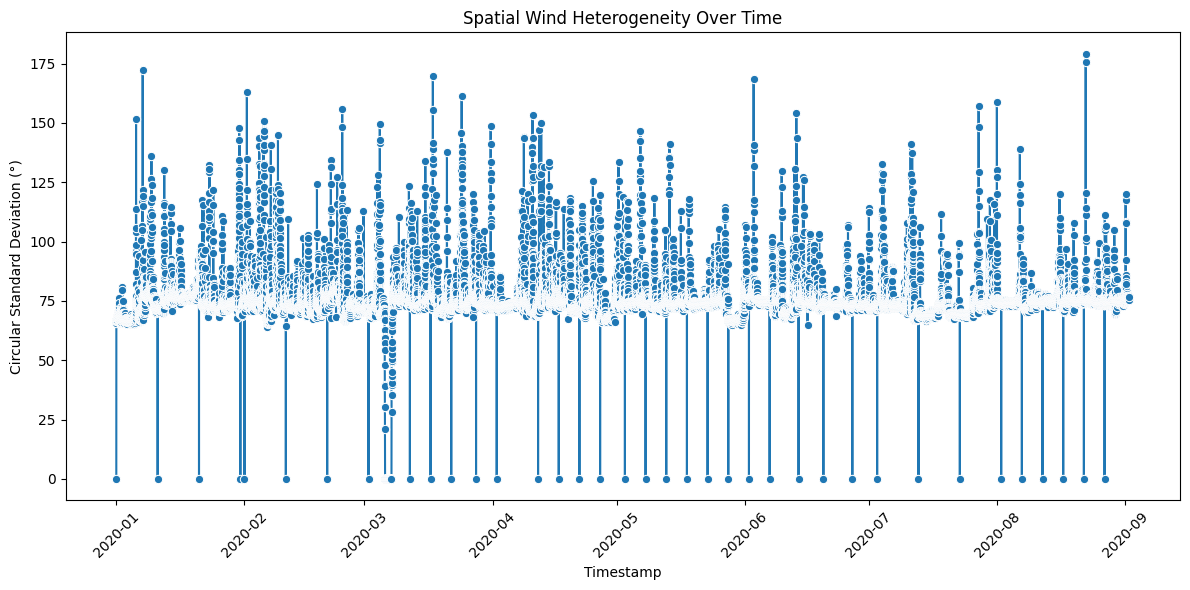

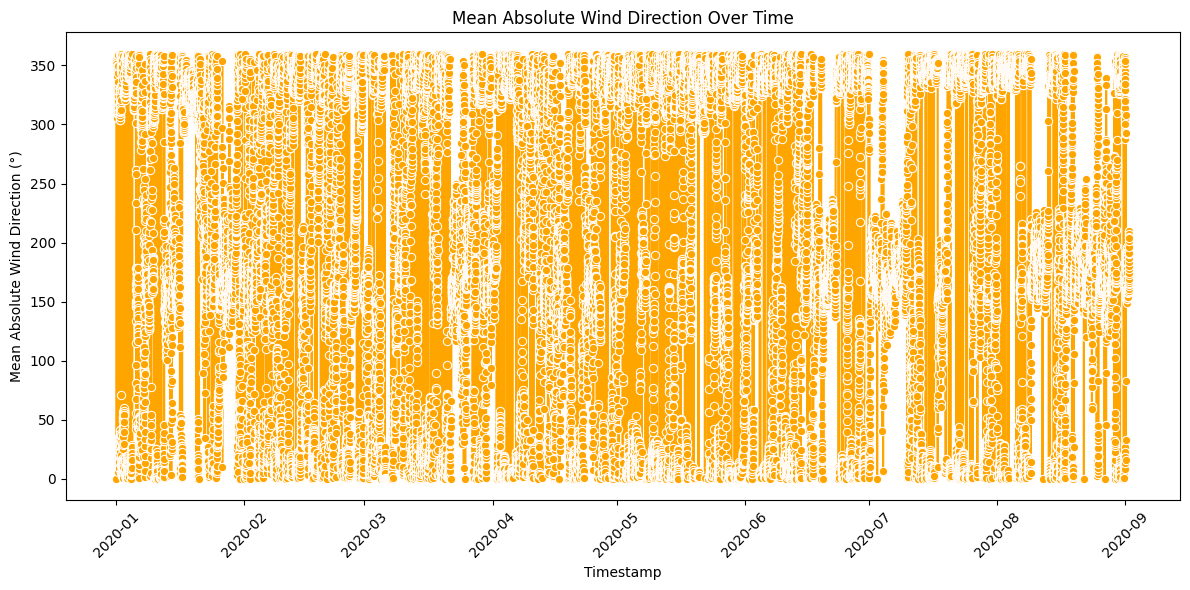

Heterogeneity Statistics:
count    35280.000000
mean        74.705412
std          9.979957
min         -0.000000
25%         72.325534
50%         73.918925
75%         75.757423
max        179.228472
Name: Heterogeneity, dtype: float64


In [6]:
import seaborn as sns

# Compute circular statistics for wind direction heterogeneity. If you have a high heterogeneity, 
# it means the wind directions are more spread out.

def circular_stats(angles_deg):
    """
    Compute circular mean and circular standard deviation (in degrees)
    for an array of angles given in degrees.
    """
    angles = np.deg2rad(angles_deg)
    mean_angle = np.angle(np.mean(np.exp(1j * angles)), deg=True) % 360
    # Compute the resultant vector length.
    R = np.abs(np.mean(np.exp(1j * angles)))
    circ_std = np.sqrt(-2 * np.log(R))  # in radians
    return mean_angle, np.rad2deg(circ_std)

# Group by timestamp (assumes df has a proper 'Datetime' column)
grouped = df.groupby('Datetime')

stats_list = []
for timestamp, group in grouped:
    angles = group['AbsWdir'].values
    if len(angles) > 0:
        mean_angle, heterogeneity = circular_stats(angles)
        stats_list.append({
            'Datetime': timestamp,
            'Mean_AbsWdir': mean_angle,
            'Heterogeneity': heterogeneity
        })

stats_df = pd.DataFrame(stats_list).sort_values('Datetime')

# Plot heterogeneity over time
plt.figure(figsize=(12,6))
sns.lineplot(data=stats_df, x='Datetime', y='Heterogeneity', marker='o')
plt.title("Spatial Wind Heterogeneity Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Circular Standard Deviation (°)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, plot the mean absolute wind direction over time
plt.figure(figsize=(12,6))
sns.lineplot(data=stats_df, x='Datetime', y='Mean_AbsWdir', marker='o', color='orange')
plt.title("Mean Absolute Wind Direction Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Mean Absolute Wind Direction (°)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (Optional) Print summary statistics of heterogeneity
print("Heterogeneity Statistics:")
print(stats_df['Heterogeneity'].describe())

In [ ]:
#here we compute the dominant wind direction per timestamp using KMeans clustering. It does not seem to be working well, because it outputs that it cannot 
#make clusters with less than K points. Any idea how to fix this would be appreciated.It seems very conflifcting with the previous conclusions, because first I
# conclude that the wind direction is very heterogeneous, but then I try to cluster it and it says that there are not enough points to form K clusters(homogeneous). 

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def dominant_wind_direction(cluster_centers, labels):
    """
    Given cluster_centers as an array of shape (K,2) in (cos, sin) space and corresponding labels,
    this function finds the dominant cluster (largest count) and returns its center (as an angle in degrees).
    """
    counts = np.bincount(labels, minlength=cluster_centers.shape[0])
    dominant_cluster = counts.argmax()
    cx, cy = cluster_centers[dominant_cluster]
    angle = (np.degrees(np.arctan2(cy, cx)) + 360) % 360
    return angle

def compute_dominant_direction_per_timestamp(df, K=3):
    """
    Groups the DataFrame by the 'Datetime' column. For each group, the function:
      - Extracts the 'AbsWdir' column (angles in degrees);
      - Embeds them into 2D space as (cos, sin) to honor circularity;
      - Runs KMeans clustering with n_clusters=K (using n_init=10 for robust seeding);
      - Selects the dominant cluster (largest number of points);
      - Computes the dominant wind direction from the cluster center;
      - Computes the circular standard deviation for that cluster.
      
    Returns a DataFrame (indexed by timestamp) with:
      - dominant_dir_deg: dominant wind direction in degrees.
      - cluster_std_deg: circular standard deviation (in degrees) of the dominant cluster.
      - cluster_size: number of points in the dominant cluster.
    """
    # Ensure 'Datetime' column exists
    if 'Datetime' not in df.columns:
        if 'Tmstamp_fixed' not in df.columns:
            df = df.copy()
            df['Tmstamp_fixed'] = df['Tmstamp'] + ":00"
        base_date = pd.to_datetime("2020-01-01")
        df['Datetime'] = base_date + pd.to_timedelta(df['Day'] - 1, unit='D') + pd.to_timedelta(df['Tmstamp_fixed'])
    
    records = []
    for ts, group in df.groupby('Datetime'):
        angles = group['AbsWdir'].values
        if len(angles) < K:
            # Not enough points to form K clusters; skip this timestamp.
            continue
        # Embed angles in 2D (cos, sin) space.
        radians = np.deg2rad(angles)
        X = np.column_stack((np.cos(radians), np.sin(radians)))
        
        # Run KMeans clustering.
        kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(X)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_
        
        # Identify the dominant cluster (largest count).
        counts = np.bincount(labels)
        dominant_cluster = counts.argmax()
        dom_angle = (np.degrees(np.arctan2(cluster_centers[dominant_cluster, 1],
                                               cluster_centers[dominant_cluster, 0])) + 360) % 360
        
        # Compute the circular standard deviation for angles in the dominant cluster.
        dom_cluster_angles = angles[labels == dominant_cluster]
        R = np.abs(np.mean(np.exp(1j * np.deg2rad(dom_cluster_angles))))
        circ_std = np.rad2deg(np.sqrt(-2 * np.log(R))) if R > 0 else 0.0
        
        records.append({
            'timestamp': ts,
            'dominant_dir_deg': dom_angle,
            'cluster_std_deg': circ_std,
            'cluster_size': len(dom_cluster_angles)
        })
        
    return pd.DataFrame(records).set_index('timestamp')

# Example usage:
# Assuming df contains a "Datetime" column and an "AbsWdir" column.
dom_df = compute_dominant_direction_per_timestamp(df, K=3)
print(dom_df)


c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklear

KeyboardInterrupt: 

In [17]:
dom_df = compute_dominant_direction_per_timestamp(df, K=3)


c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\daank\GML\venv\Lib\site-packages\sklear

Dominant wind direction: 359.75°
Dominant cluster size: 230
Circular std of dominant cluster: 15.49°


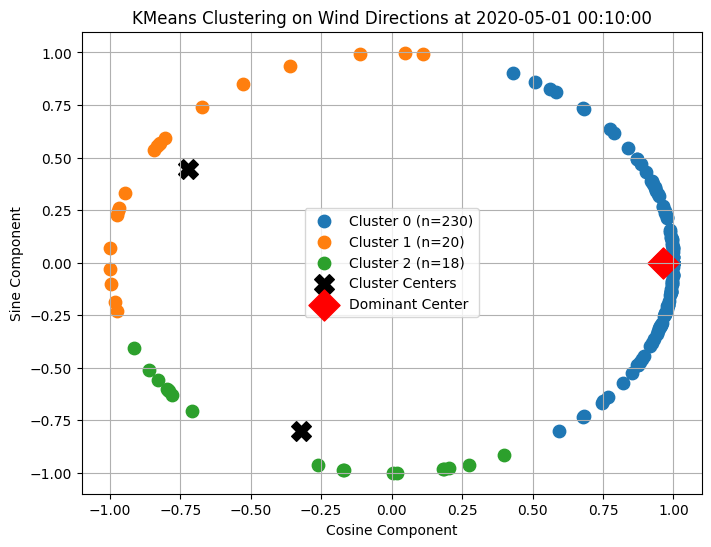

[0.0000e+00 2.1930e+01 0.0000e+00 1.8520e+01 0.0000e+00 2.7020e+02
 0.0000e+00 2.7980e+01 0.0000e+00 3.4586e+02 0.0000e+00 5.9430e+01
 0.0000e+00 5.5750e+01 0.0000e+00 1.4554e+02 0.0000e+00 3.1267e+02
 0.0000e+00 3.4523e+02 0.0000e+00 6.2800e+00 0.0000e+00 4.3900e+00
 0.0000e+00 1.4270e+01 0.0000e+00 6.5600e+00 0.0000e+00 1.4747e+02
 0.0000e+00 1.6100e+00 0.0000e+00 1.9334e+02 0.0000e+00 2.9490e+01
 0.0000e+00 2.9352e+02 0.0000e+00 2.5490e+01 0.0000e+00 1.6074e+02
 0.0000e+00 3.3050e+01 0.0000e+00 3.9500e+00 0.0000e+00 2.1749e+02
 0.0000e+00 3.5948e+02 0.0000e+00 2.8169e+02 0.0000e+00 3.5634e+02
 0.0000e+00 6.8700e+00 0.0000e+00 2.0070e+01 0.0000e+00 3.5187e+02
 0.0000e+00 2.5482e+02 0.0000e+00 6.8200e+00 0.0000e+00 8.3640e+01
 0.0000e+00 2.0740e+01 0.0000e+00 3.3872e+02 0.0000e+00 8.4300e+00
 0.0000e+00 2.1069e+02 0.0000e+00 8.7310e+01 0.0000e+00 2.2480e+02
 0.0000e+00 3.2836e+02 0.0000e+00 3.3071e+02 0.0000e+00 1.9070e+01
 0.0000e+00 1.8000e-01 0.0000e+00 1.9080e+02 0.0000e+00 2.8584

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Choose a specific timestamp (adjust as needed)
ts = pd.to_datetime("2020-05-01 00:10:00")
# Select multiple timestamps (example: first 3 unique timestamps in the DataFrame)
timestamps = df['Datetime'].sort_values().unique()[:2]
# Filter the DataFrame for those timestamps (assumes 'Datetime' is already in df)
df_ts = df[df['Datetime'].isin(timestamps)].copy()
angles = df_ts['AbsWdir'].values

# Define number of clusters
K = 3

if len(angles) < K:
    print("Not enough points to run KMeans clustering.")
else:
    # Embed angles into 2D (cos, sin) space to preserve circularity.
    radians = np.deg2rad(angles)
    X = np.column_stack((np.cos(radians), np.sin(radians)))
    
    # Run KMeans clustering.
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(X)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    # Identify the dominant cluster (largest count)
    counts = np.bincount(labels)
    dominant_cluster = counts.argmax()
    dom_angle = (np.degrees(np.arctan2(cluster_centers[dominant_cluster, 1],
                                           cluster_centers[dominant_cluster, 0])) + 360) % 360
    
    # Optionally, compute circular standard deviation for the dominant cluster.
    dom_cluster_angles = angles[labels == dominant_cluster]
    R = np.abs(np.mean(np.exp(1j * np.deg2rad(dom_cluster_angles))))
    circ_std = np.rad2deg(np.sqrt(-2 * np.log(R))) if R > 0 else 0.0
    
    print("Dominant wind direction: {:.2f}°".format(dom_angle))
    print("Dominant cluster size:", len(dom_cluster_angles))
    print("Circular std of dominant cluster: {:.2f}°".format(circ_std))
    
    # Plot the clustering results in the embedded [cos, sin] space.
    plt.figure(figsize=(8, 6))
    for cluster in range(K):
        idx = np.where(labels == cluster)[0]
        plt.scatter(X[idx, 0], X[idx, 1], label=f"Cluster {cluster} (n={len(idx)})", s=80)
    # Plot all cluster centers.
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                marker='X', s=200, color='black', label="Cluster Centers")
    # Highlight the dominant cluster center.
    plt.scatter(cluster_centers[dominant_cluster, 0], cluster_centers[dominant_cluster, 1],
                marker='D', s=250, color='red', label="Dominant Center")
    
    plt.title(f"KMeans Clustering on Wind Directions at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    plt.xlabel("Cosine Component")
    plt.ylabel("Sine Component")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(angles)
    print(timestamps)
    

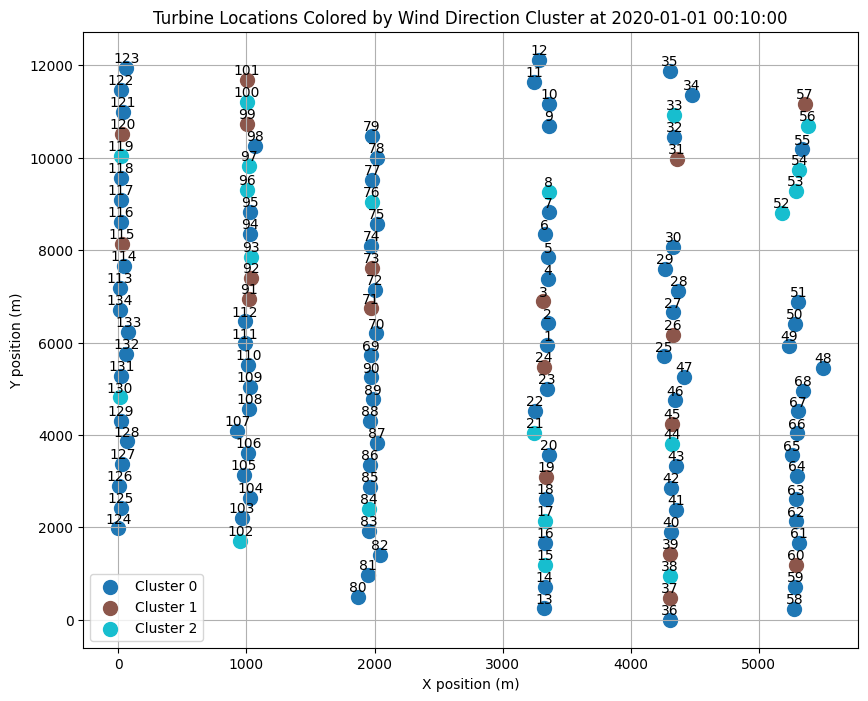

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- Assume df and df_loc are already loaded ---
# Compute the absolute wind direction if not already done
# def normalize_angle(angle):
#     return angle % 360

# def compute_absolute_wind_direction(df):
#     df = df.copy()
#     df['Wdir'] = df['Wdir'].fillna(0)
#     df['Ndir'] = df['Ndir'].fillna(0)
#     df['AbsWdir'] = (df['Ndir'] + df['Wdir']).apply(normalize_angle)
#     return df

# Apply if needed (uncomment if df does not have AbsWdir already)
df = compute_absolute_wind_direction(df)

# Filter for a specific timestamp (example: '2020-01-01 00:10:00')
ts = pd.to_datetime("2020-01-01 00:10:00")
df_t0 = df[(df['Day'] == 1) & (df['Tmstamp'].str.startswith("00:10"))].sort_values('TurbID')

# Merge turbine location data (df_loc should contain at least 'TurbID', 'x', 'y')
df_t0 = df_t0.merge(df_loc, on='TurbID', how='left')

# Extract the absolute wind direction values for clustering
angles = df_t0['AbsWdir'].values

# Define number of clusters
K = 3

if len(angles) < K:
    print("Not enough points for KMeans clustering.")
else:
    # Embed angles into 2D (cos, sin) space to preserve circularity.
    radians = np.deg2rad(angles)
    X = np.column_stack((np.cos(radians), np.sin(radians)))
    
    # Run KMeans clustering.
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(X)
    labels = kmeans.labels_
    
    # Assign the cluster labels to the turbine DataFrame.
    df_t0['cluster'] = labels

    # Define a discrete colormap (using tab10 for up to 10 distinct colors).
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    # Plot the turbine locations with color corresponding to the cluster.
    plt.figure(figsize=(10, 8))
    for cluster in range(K):
        sub = df_t0[df_t0['cluster'] == cluster]
        plt.scatter(sub['x'], sub['y'], color=colors[cluster], s=100,
                    label=f"Cluster {cluster}")
    # Optionally, add turbine IDs as text.
    for i, row in df_t0.iterrows():
        plt.text(row['x'], row['y']+50, str(row['TurbID']), fontsize=10,
                 ha='center', va='bottom', color='black')
                 
    plt.title(f"Turbine Locations Colored by Wind Direction Cluster at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
import matplotlib.pyplot as plt

# Compute the dominant direction DataFrame if not already done
dom_df = compute_dominant_direction_per_timestamp(df, K=3)

# Sort the DataFrame by timestamp and select the first 10 entries
first10 = dom_df.sort_index().head(10)

plt.figure(figsize=(12, 6))
plt.plot(first10.index, first10['dominant_dir_deg'], marker='o', linestyle='-', label='Dominant Direction')
plt.xlabel("Timestamp")
plt.ylabel("Dominant Wind Direction (°)")
plt.title("Dominant Wind Direction for First 10 Timestamps")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'compute_dominant_direction_per_timestamp' is not defined